<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/notebooks/overal_abundance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [1]:
!pip install BIO

In [2]:
!git clone https://github.com/alibekk93/IDP_analysis.git
!cd IDP_analysis/

fatal: destination path 'IDP_analysis' already exists and is not an empty directory.


In [3]:
from IDP_analysis.packages_import import *
from IDP_analysis.idp_in_bacteria_functions import *

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
sns.set_theme(context='paper', style='white',  palette='colorblind')

Loading Tempura dataset

In [70]:
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/200617_TEMPURA.csv', index_col=0)
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [71]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Classifying bacteria into groups:
1. Psychrophile: OGT <= 20
2. Mesophile: 20 < OGT <= 40
2. Thermophile: 40 < OGT

While this may be quite liberal, some "psychrohiles" with OGT = 20 have *antarctica* in their species name, so it should be fair enough

Psychromphiles would be dropped from this version

In [72]:
tempura = tempura[tempura['Topt_ave'] > 20]
tempura['group'] = ['thermophilic' if t >= 40 else 'mesophilic' for t in tempura['Topt_ave']]

<ipython-input-72-451f8cf8d5ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempura['group'] = ['thermophilic' if t >= 40 else 'mesophilic' for t in tempura['Topt_ave']]


Loading all_proteins

In [73]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
# all_proteins = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)
all_proteins = pd.read_csv('/content/all_proteins_types.csv', index_col=0)

Merging all_proteins with temura

In [74]:
all_proteins = all_proteins.merge(tempura, left_on='Species', right_on='genus_and_species')

setting colors

In [121]:
green = '#1BE434'
red = '#E4341B'

## EDA

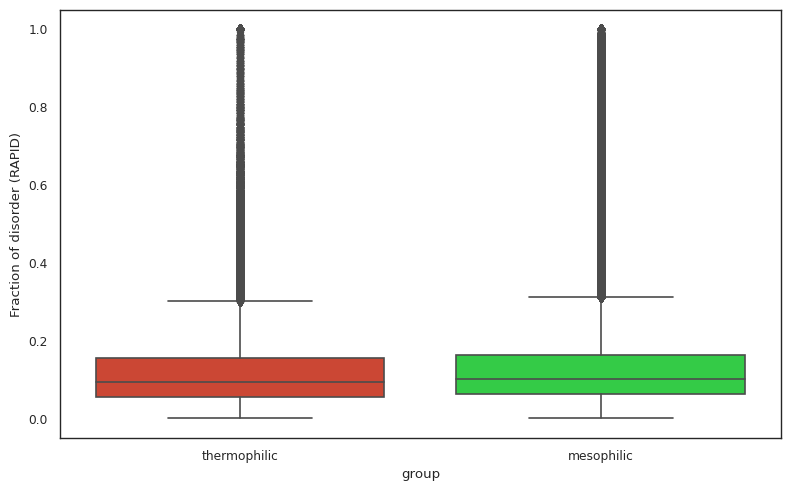

In [125]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(data=all_proteins, x='group', y='RAPID_disorder', palette=[red, green], ax=ax, )
plt.ylabel('Fraction of disorder (RAPID)')

plt.tight_layout()

fig.show()
# fig.savefig('FOD_RAPID_box.svg')

<Axes: xlabel='candidate_idp', ylabel='RAPID_disorder'>

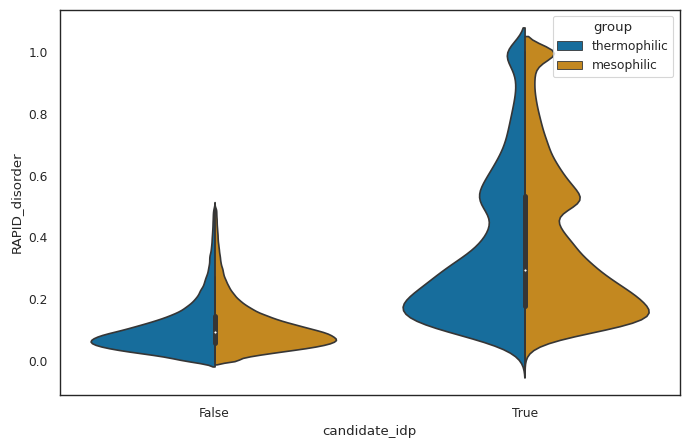

In [98]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.violinplot(data=all_proteins, x='candidate_idp', y='RAPID_disorder', split=True, hue='group')

<Axes: xlabel='candidate_idp', ylabel='Genome_GC'>

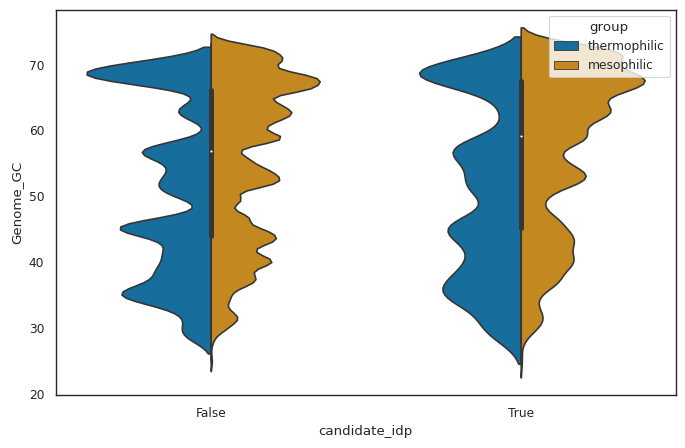

In [99]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.violinplot(data=all_proteins, x='candidate_idp', y='Genome_GC', split=True, hue='group')

In [126]:
X = all_proteins.groupby('Species').mean(numeric_only=True)['Topt_ave']
y = all_proteins.groupby('Species').mean(numeric_only=True)['RAPID_disorder']
# y = all_proteins.groupby('Species').mean(numeric_only=True)['fIDP_disorder']

FOD_OGT_line_model = sm.OLS(y, sm.add_constant(X)).fit()
print(FOD_OGT_line_model.summary())

                            OLS Regression Results                            
Dep. Variable:         RAPID_disorder   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.760
Date:                Fri, 15 Dec 2023   Prob (F-statistic):             0.0299
Time:                        20:58:45   Log-Likelihood:                 670.06
No. Observations:                 304   AIC:                            -1336.
Df Residuals:                     302   BIC:                            -1329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1428      0.005     28.533      0.0

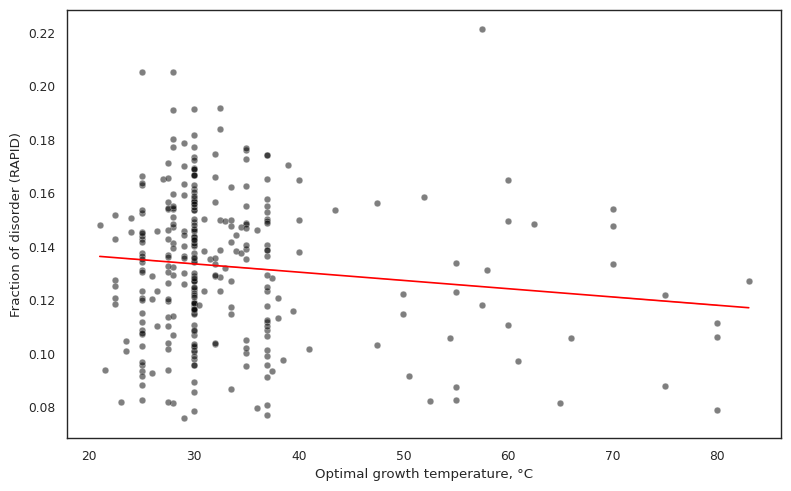

In [127]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(x=X, y=y, color='black', ax=ax, alpha=0.5)
plt.ylabel('Fraction of disorder (RAPID)')
plt.xlabel('Optimal growth temperature, °C')

sns.lineplot(x=X, y=FOD_OGT_line_model.predict(sm.add_constant(X)), ax=ax, color='red')
plt.tight_layout()

fig.show()
# fig.savefig('FOD_RAPID_OGT_scatter.svg')

In [76]:
all_proteins.groupby('group', as_index=False).mean()

<ipython-input-76-451bbec4b5d3>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_proteins.groupby('group', as_index=False).mean()


,group,Length,RAPID_disorder,f_plus,f_minus,ncpr,fcr,idp_type,candidate_idp,taxonomy_id,Genome_GC,Genome_size,16S_GC,Tmin,Topt_ave,Topt_low,Topt_high,Tmax,Tmax_Tmin
0,mesophilic,326.530357,0.13637,0.128921,0.116845,0.032080,0.245766,1.549133,0.082855,1.091617e+06,55.402709,5.251804,55.026041,12.885700,29.896327,26.116425,31.786984,38.556674,25.670975
1,thermophilic,299.503371,0.13015,0.139548,0.121058,0.033608,0.260606,1.700351,0.096101,6.809963e+05,50.396855,3.207869,58.585005,37.629185,56.853962,48.882716,53.367369,66.412142,28.782957
